## I. Setting
### 1. Packages

In [24]:
# Import packages
import os, sys, shutil, warnings, random, glob, pylab, numpy as np, pandas as pd, time, datetime
from tqdm import tqdm

# packages for visualization
import pydicom, cv2, seaborn as sns, matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image
from imgaug import augmenters as iaa

# packages for model
import tensorflow as tf, keras
from keras.callbacks import EarlyStopping
from keras.backend.tensorflow_backend import set_session
from keras.models import load_model
from sklearn.model_selection import KFold, train_test_split

In [25]:
#### Package settings

# Display up to 50 columns of a pandas dataframe
pd.set_option('display.max_columns',50)
# ignore warnings
warnings.filterwarnings("ignore")

# Limit GPU usage to 80%
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=tf_config))

### 2. Directory

In [26]:
# The home directory of this project
root_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish'
# Ocean asset directories
# Image data
assets_image_data =('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/')
# Meta data (dataframe and array data)
assets_meta_data =('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/meta_data/')
# Visualization 
visual_DIR =('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets_visualization/')




# full data: includes all images 
full_image=('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/')
# full image data directories for training using 
full_train = ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/full_train/')
full_validate = ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/full_validate/')
full_test= ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/full_test/')

# full meta data (dataframe and array data)
full_meta = ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/meta_data/full_meta/')
# full visualization 
full_visual=('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets_visualization/full_visual/')

#full_dirs = ['full_train','full_validate','full_test']
#for DIR in full_dirs:
    #os.mkdir(os.path.join(full_image,DIR))  

# Sample model 
bdbm = ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model')

print(full_image)
print(full_train)
print(full_validate)
print(full_test)
print(full_meta)
print(full_visual)
print(bdbm)


/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/full_train/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/full_validate/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/full_test/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/meta_data/full_meta/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets_visualization/full_visual/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model


### Import Mask RCNN library

In [27]:
# Import Mask RCNN
sys.path.append(os.path.join(root_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [28]:
# Model Directory
MASK_RCNN = os.path.join(root_DIR,'src/Mask_RCNN')
COCO_WEIGHTS_PATH = os.path.join(root_DIR,'src/Mask_RCNN_coco_weights/mask_rcnn_coco.h5')
models_working_DIR = os.path.join(root_DIR,'src/models_working')
print(MASK_RCNN)
print(COCO_WEIGHTS_PATH)
print(models_working_DIR)

/home/ubuntu/healthcare/pneumonia_lungfish/src/Mask_RCNN
/home/ubuntu/healthcare/pneumonia_lungfish/src/Mask_RCNN_coco_weights/mask_rcnn_coco.h5
/home/ubuntu/healthcare/pneumonia_lungfish/src/models_working


## II. Data 

### Full dataset (N= 26684) 

### 1. Prepare train, validate, and test image dat

In [29]:
def get_dicom(dicom_dir):
    train_dicom = glob.glob(dicom_dir+'/'+'*.dcm') #a list of the dicom image path and filenames
    return list(set(train_dicom))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps} #a dictionary of the annotations keyed by the filenames
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId'] + '.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [30]:
# Create lists of images
full_train_dcm =get_dicom(full_train)
full_validate_dcm = get_dicom(full_validate)
full_test_dcm= get_dicom(full_test)
print(len(full_train_dcm), 'images are found in','full_train')
print(len(full_validate_dcm), 'images are found in','full_validate')
print(len(full_test_dcm), 'images are found in','full_test')

24015 images are found in full_train
1334 images are found in full_validate
1335 images are found in full_test


### 2. Prepare train, validate, and test annotation data
#### Annotation data: we will use the dataframe we prepare from Notebook00

In [31]:
ann= pd.read_csv(os.path.join(full_meta,'df_target_path_box.csv'))
ann.head(1)

,patientId,Target,image_path,x,y,width,height
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,/home/ubuntu/healthcare/pneumonia_lungfish/src...,NaN,NaN,NaN,NaN


In [32]:
# filter a dataframe by image name
def filter_df_by_image_list(df,image_name,image_dir,new_df_name,save_df_dir):
    #remove the extention from image file name (e.g. .dcm)

    f = [os.path.splitext(e.name)[0] for e in os.scandir(image_dir) if e.is_file()]

    # filter df using the above list
    df_filtered =  df[df[image_name].isin(f)]
    print(df_filtered[image_name].nunique(),'unique',image_name,'in',image_dir)
    
    name= str(new_df_name) +'.csv'
    
    df_filtered.to_csv(os.path.join(save_df_dir,name),index= False)
    return df_filtered

In [33]:
ann_train = filter_df_by_image_list(ann,'patientId',full_train,'annotaion_data_full_train',full_meta)
ann_validate = filter_df_by_image_list(ann,'patientId',full_validate,'annotaion_data_full_validate',full_meta)
ann_test = filter_df_by_image_list(ann,'patientId',full_test,'annotaion_data_full_test',full_meta)

24015 unique patientId in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/full_train/
1334 unique patientId in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/full_validate/
1335 unique patientId in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/full_image/full_test/


In [34]:
image_fps_train, image_annotations_train =parse_dataset(full_train, ann_train)
image_fps_validate, image_annotations_validate =parse_dataset(full_validate, ann_validate)
image_fps_test, image_annotations_test =parse_dataset(full_test, ann_test)
print('train:',len(image_fps_train), ';', 'validation: ', len(image_fps_validate),';','test:', len(image_fps_test))


train: 24015 ; validation:  1334 ; test: 1335


## III. Model

In [35]:
# Original DICOM pixel array is 1024(Rows) x1024(Columns)
ORIG_SIZE = 1024

In [36]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200
    
    #changed 
    LEARNING_RATE = 0.003

config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.003
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [37]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            
            annotations = image_annotations[fp]

            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
 
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(infor['path'])
        return info['path'] #patient_id_as key

    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']#
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)
   

In [38]:
# prepare the train dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations_train, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_validate = DetectorDataset(image_fps_validate, image_annotations_validate, ORIG_SIZE, ORIG_SIZE)
dataset_validate.prepare()

# prepare the test dataset
dataset_test = DetectorDataset(image_fps_test, image_annotations_test, ORIG_SIZE, ORIG_SIZE)
dataset_test.prepare()

## Training 1: initialize using Coco weights 

In [50]:
model_path = COCO_WEIGHTS_PATH
model = modellib.MaskRCNN(mode='training', config=config, model_dir=models_working_DIR)

# Exclude the last layers because they require a matching
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])


### 1. Add an early stopping

In [51]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


### 2. Add class weights
There are 22.5% which are class 1, and 77.5%  which are class 0.  
I balance 2 classes using the class_weights class_weight = {0:77.5,1:22.5}

In [53]:
class_weight = {0:77.5,1:22.5}

### 3. Train

In [ ]:
model.train(dataset_train, dataset_validate,
            learning_rate=config.LEARNING_RATE, #0.003
            epochs=5,
            layers='all',
            augmentation=None, ## No image augmentation
            custom_callbacks = [es],
            class_weight = class_weight,)  ## early stopping

In [ ]:
# Function to save history in a csv file
def df_history(model,save_dir):
    history = model.keras_model.history.history
    epochs = range(1,len(next(iter(history.values())))+1)
    
    df = pd.DataFrame(history, index=epochs)
    csvname = '{}{:%Y%m%dT%H%M%S}.csv'.format(('big_data_big_model_history'), datetime.datetime.now())
    
    df.to_csv(os.path.join(save_dir,csvname))
    return df 
    

In [55]:
df_history(model,bdbm)

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.743575,0.521432,0.229210,0.458378,0.515594,0.018953,1.818490,0.684223,0.266230,0.433887,0.417424,0.016718
2,1.539890,0.446881,0.187129,0.394997,0.497410,0.013465,1.946302,0.547492,0.403321,0.461475,0.519601,0.014405
3,1.480860,0.435820,0.213943,0.405794,0.410792,0.014502,1.757620,0.555353,0.277852,0.431516,0.478632,0.014259
4,1.396893,0.418923,0.183966,0.393314,0.390227,0.010456,1.495220,0.390692,0.197790,0.386097,0.506327,0.014307
5,1.253761,0.362881,0.173208,0.370264,0.336001,0.011400,1.771260,0.519851,0.279929,0.477975,0.483493,0.010004


In [2]:
# Function to plot and save history 
def plot_history(model,save_dir):
    history = model.keras_model.history.history
    epochs = range(1,len(next(iter(history.values())))+1)
    
    fig = plt.figure(figsize=(15,5))

    plt.subplot(131)
    plt.plot(epochs, history["loss"], label="Train loss")
    plt.plot(epochs, history["val_loss"], label="Valid loss")
    plt.legend()
    plt.subplot(132)
    plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
    plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
    plt.legend()
    plt.subplot(133)
    plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
    plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
    plt.legend()

    plt.show()
    figname = '{}{:%Y%m%dT%H%M%S}.png'.format(('big_data_big_model_history'), datetime.datetime.now())
    fig.savefig(os.path.join(bdbm,figname),figdpi = 600)
    plt.close()

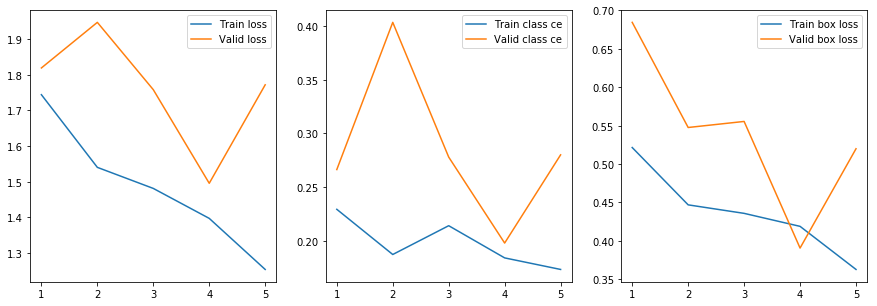

In [57]:
# plot history 
plot_history(model,bdbm)

In [58]:
# select best epoch
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 4 1.495220057964325


### 4. Validation

In [ ]:
# This is the path of the best model in the run 
model_path = os.path.join(models_working_DIR,'pneumonia20190312T1714','mask_rcnn_pneumonia_0004.h5')
# Make a copy of the best model and change name
shutil.copy(model_path, bdbm)
os.rename('mask_rcnn_pneumonia_0004.h5', 'pneumonia20190312T1714_mask_rcnn_pneumonia_0004.h5')
best_model= os.path.join(bdbm,'pneumonia20190312T1714_mask_rcnn_pneumonia_0004.h5')

In [64]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=best_model)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", best_model)
model.load_weights(best_model, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/pneumonia20190312T1714_mask_rcnn_pneumonia_0004.h5


In [65]:
# Set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 

625

*** No instances to display *** 

301
620

*** No instances to display *** 

697

*** No instances to display *** 

1070
1193


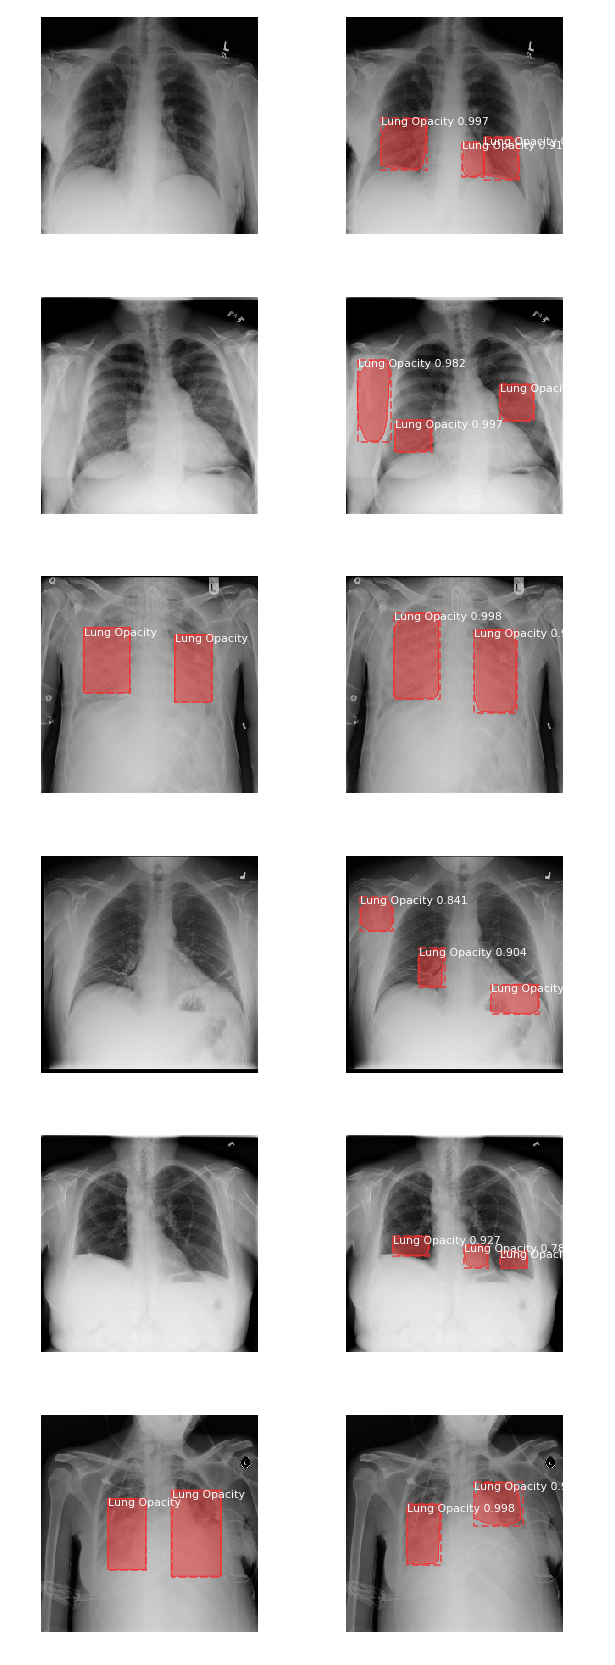

In [80]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_validate
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_validate, inference_config, 
                               image_id, use_mini_mask=False)
    
    #print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, #verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    print(image_id)
    

In [81]:
# Save the plot
figname = '{}{:%Y%m%dT%H%M%S}.png'.format(('big_data_big_model_epoch5_inference6_2_cap'), datetime.datetime.now())
fig.savefig(os.path.join(bdbm,figname),figdpi = 600)
plt.close()

In [66]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='validation_result.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [90]:
# Name your csv with date and time
filename = '{}{:%Y%m%dT%H%M%S}.csv'.format(('big_data_big_model_epoch5_inference_validation'), datetime.datetime.now())
validation_result_fp = os.path.join(bdbm, filename)
print('Inference Result on validation dataset is saved in', validation_result_fp)
predict(image_fps_validate, filepath=validation_result_fp)


Inference Result on validation dataset is saved in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/big_data_big_model_epoch5_inference_validation20190312T175613.csv


## Training 2: Use the above best_model weight from Training 1

In [93]:
best_model= os.path.join(bdbm,'pneumonia20190312T1714_mask_rcnn_pneumonia_0004.h5')
model_path = best_model

# Prepare model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=models_working_DIR)
# Exclude the last layers because they require a matching

model.load_weights(model_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
print("Loading weights from ", model_path)


Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/pneumonia20190312T1714_mask_rcnn_pneumonia_0004.h5


### 1. Add data augmentation 

In [92]:
# Image augmentation (horizontal flip)
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(1.0)
])

# The same to Training 1
# Add early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

# Add class weights for unbalanced dataset 
class_weight = {0:77.5,1:22.5}

### 2. Train

In [94]:


model.train(dataset_train, dataset_validate,
            learning_rate=config.LEARNING_RATE, #0.003
            epochs=5,
            layers='all',
            augmentation=augmentation, ## Image augmentation!!
            custom_callbacks = [es],
            class_weight = class_weight,)  ## early stopping



Starting at epoch 0. LR=0.003

Checkpoint Path: /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190312T1803/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
r

### Inspect training history

In [98]:
# From now on, we use a function to save history in a csv file
def df_history(model,save_dir):
    history = model.keras_model.history.history
    epochs = range(1,len(next(iter(history.values())))+1)
    
    df = pd.DataFrame(history, index=epochs)
    csvname = '{}{:%Y%m%dT%H%M%S}.csv'.format(('big_data_big_model_history'), datetime.datetime.now())
    
    df.to_csv(os.path.join(save_dir,csvname))
    return df 
    

In [99]:
df_history(model,bdbm)

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.575927,0.478879,0.228711,0.410815,0.444170,0.013345,1.588555,0.526302,0.214886,0.438497,0.397631,0.011231
2,1.328615,0.377896,0.164569,0.376779,0.398445,0.010918,1.610460,0.476365,0.149226,0.409138,0.564153,0.011570
3,1.222943,0.368140,0.150423,0.377148,0.318276,0.008949,1.582505,0.537543,0.129966,0.469004,0.438033,0.007952
4,1.288009,0.339032,0.150129,0.378228,0.410636,0.009977,1.514326,0.425828,0.189936,0.392876,0.494811,0.010868
5,1.162025,0.328111,0.135381,0.360552,0.330117,0.007857,1.747472,0.445646,0.222112,0.432028,0.635938,0.011740


In [96]:
# Function to plot and save history 
def plot_history(model,save_dir):
    history = model.keras_model.history.history
    epochs = range(1,len(next(iter(history.values())))+1)
    
    fig = plt.figure(figsize=(15,5))

    plt.subplot(131)
    plt.plot(epochs, history["loss"], label="Train loss")
    plt.plot(epochs, history["val_loss"], label="Valid loss")
    plt.legend()
    plt.subplot(132)
    plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
    plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
    plt.legend()
    plt.subplot(133)
    plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
    plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
    plt.legend()

    plt.show()
    figname = '{}{:%Y%m%dT%H%M%S}.png'.format(('big_data_big_model_history'), datetime.datetime.now())
    fig.savefig(os.path.join(bdbm,figname),figdpi = 600)
    plt.close()

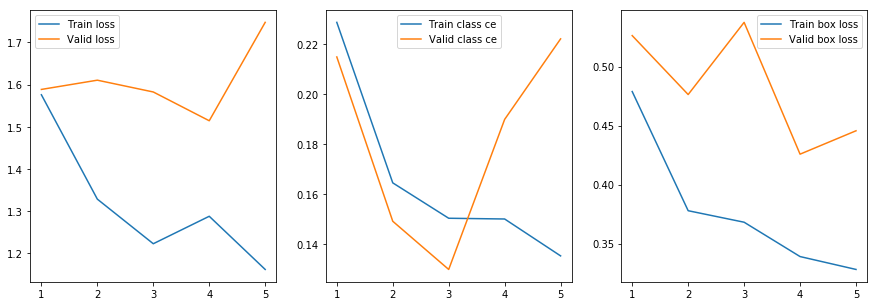

In [97]:
# plot history 
plot_history(model,bdbm)

In [ ]:
best_epoch = np.argmin(history["val_loss"])
# best_epoch is epoch 4

### 3. Validation

In [117]:
# This is the path of the best model in the run 
model_path = os.path.join(models_working_DIR,'pneumonia20190312T1803','mask_rcnn_pneumonia_0004.h5')
# Make a copy of the best model and change name
shutil.copy(model_path, bdbm)
os.rename('mask_rcnn_pneumonia_0004.h5', 'pneumonia20190312T1803_mask_rcnn_pneumonia_0004.h5')
best_model= os.path.join(bdbm,'pneumonia20190312T1803_mask_rcnn_pneumonia_0004.h5')

In [118]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=best_model)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", best_model)
model.load_weights(best_model, by_name=True)

Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/pneumonia20190312T1803_mask_rcnn_pneumonia_0004.h5


In [119]:
# Predict using validation dataset
filename = '{}{:%Y%m%dT%H%M%S}.csv'.format(('big_data_big_model_augm_1803epoch4_inference_validation'), datetime.datetime.now())
validation_result_fp = os.path.join(bdbm, filename)
print('Inference Result on validation dataset is saved in', validation_result_fp)
predict(image_fps_validate, filepath=validation_result_fp)


  0%|          | 0/1334 [00:00<?, ?it/s]

Inference Result on validation dataset is saved in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/big_data_big_model_augm_1803epoch4_inference_validation20190312T184131.csv


100%|██████████| 1334/1334 [04:28<00:00,  5.16it/s]



*** No instances to display *** 

57

*** No instances to display *** 

1297
396
374

*** No instances to display *** 

679

*** No instances to display *** 

1141


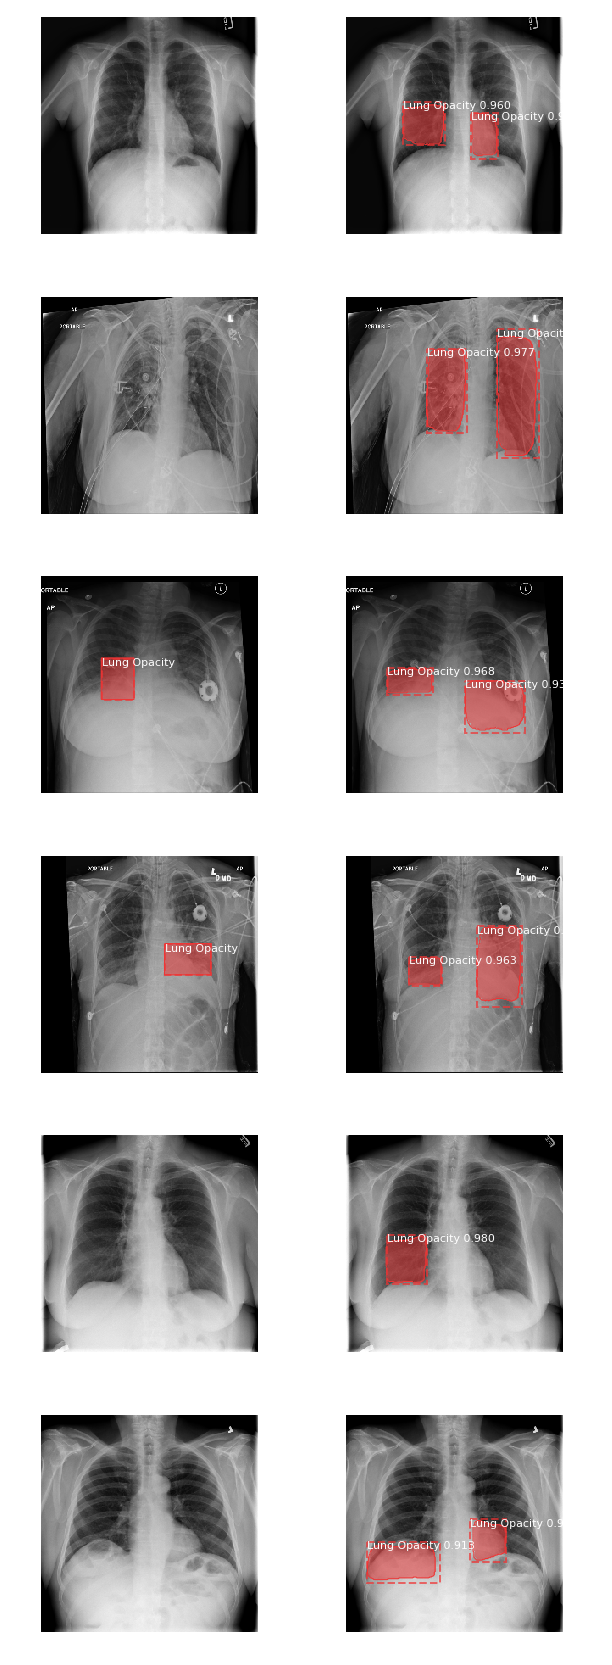

In [123]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_validate
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_validate, inference_config, 
                               image_id, use_mini_mask=False)
    
    #print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, #verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    print(image_id)
    

In [124]:
figname = '{}{:%Y%m%dT%H%M%S}.png'.format(('big_data_big_model_augm_1803epoch4_inference_validation_6_2_cap'), datetime.datetime.now())
fig.savefig(os.path.join(bdbm,figname),figdpi = 600)
plt.close()

## Training 3: Use the above best_model weight from Training 2

In [127]:
best_model= os.path.join(bdbm,'pneumonia20190312T1803_mask_rcnn_pneumonia_0004.h5')
model_path = best_model

# Prepare model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=models_working_DIR)
# Exclude the last layers because they require a matching

model.load_weights(model_path, by_name=True)
print("Loading weights from ", model_path)


Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/pneumonia20190312T1803_mask_rcnn_pneumonia_0004.h5


### 1. Don't use MINI-MASK

In [125]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## 
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200
    
    #changed 
    LEARNING_RATE = 0.003
    USE_MINI_MASK =False ###

config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.003
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### 2. Train

In [128]:

model.train(dataset_train, dataset_validate,
            learning_rate=config.LEARNING_RATE, #0.003
            epochs=5,
            layers='all',
            augmentation=augmentation, ## Image augmentation!!
            custom_callbacks = [es],
            class_weight = class_weight,)  ## early stopping



Starting at epoch 0. LR=0.003

Checkpoint Path: /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190312T1857/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
r

In [129]:
df_history(model,bdbm)

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.320473,0.392329,0.169575,0.383640,0.365050,0.009870,1.810981,0.504174,0.148987,0.397401,0.747743,0.012669
2,1.268300,0.370899,0.160526,0.372575,0.354527,0.009765,1.694013,0.412626,0.170246,0.403822,0.694760,0.012552
3,1.323063,0.397224,0.171238,0.380322,0.364549,0.009721,1.845693,0.553574,0.390701,0.442769,0.443350,0.015291
4,1.148673,0.335307,0.136010,0.352805,0.315209,0.009334,1.437312,0.454093,0.161513,0.412567,0.396186,0.012945
5,1.135758,0.329971,0.116028,0.356096,0.325411,0.008244,1.787689,0.473820,0.201912,0.422759,0.673758,0.015431


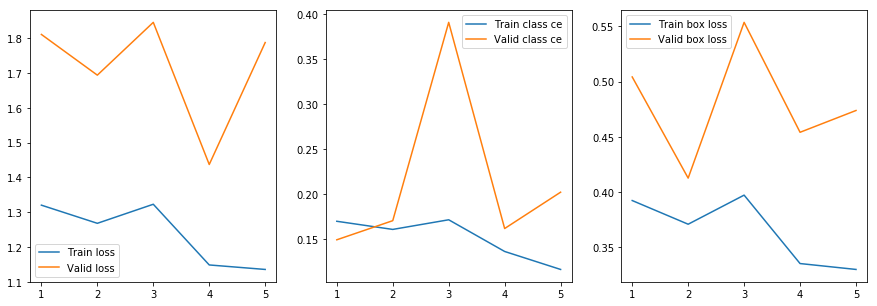

In [130]:
plot_history(model,bdbm)

In [145]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])
   

Best Epoch: 4 1.4373122453689575


### 4. Validation

In [146]:
model_path = os.path.join(models_working_DIR,'pneumonia20190312T1857','mask_rcnn_pneumonia_0004.h5')

shutil.copy(model_path, bdbm)
os.rename('mask_rcnn_pneumonia_0004.h5', 'pneumonia20190312T1857_mask_rcnn_pneumonia_0004.h5')
best_model= os.path.join(bdbm,'pneumonia20190312T1857_mask_rcnn_pneumonia_0004.h5')


In [151]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=best_model)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", best_model)
model.load_weights(best_model, by_name=True)

Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/pneumonia20190312T1857_mask_rcnn_pneumonia_0004.h5


In [148]:
# Test on validation dataset
filename = '{}{:%Y%m%dT%H%M%S}.csv'.format(('big_data_big_model_augm_mini_mask_1857epoch4_inference_validation'), datetime.datetime.now())
validation_result_fp = os.path.join(bdbm, filename)
print('Inference Result on validation dataset is saved in', validation_result_fp)
predict(image_fps_validate, filepath=validation_result_fp)


  0%|          | 0/1334 [00:00<?, ?it/s]

Inference Result on validation dataset is saved in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/big_data_big_model_augm_1803epoch4_inference_validation20190312T193627.csv


100%|██████████| 1334/1334 [04:20<00:00,  5.32it/s]


1068

*** No instances to display *** 

925

*** No instances to display *** 

66

*** No instances to display *** 

892
1323
67


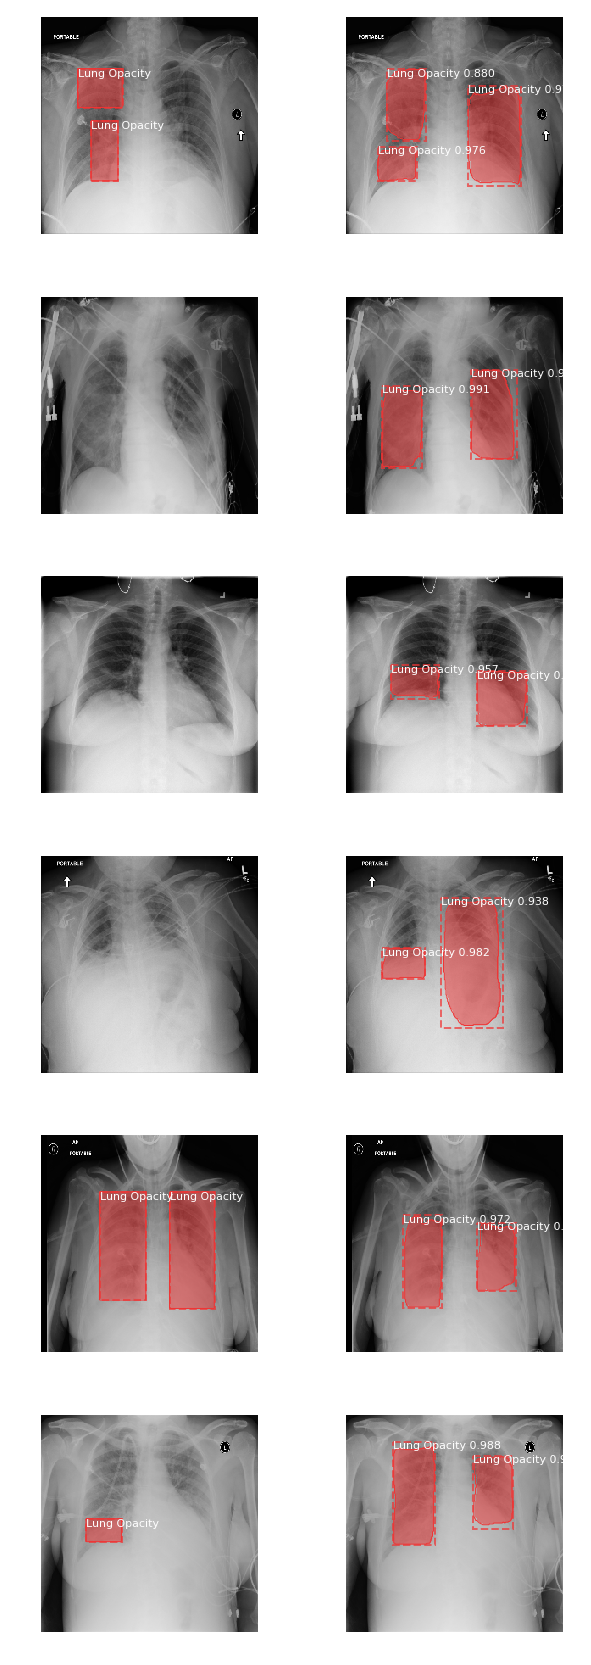

In [162]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_validate
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_validate, inference_config, 
                               image_id, use_mini_mask=False)
    
    #print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, #verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    print(image_id)
    


In [163]:
figname = '{}{:%Y%m%dT%H%M%S}.png'.format(('big_data_big_model_augm_mini_mask_1857epoch4_validation_6_3_cap'), datetime.datetime.now())
fig.savefig(os.path.join(bdbm,figname),figdpi = 600)
plt.close()

## Training 4: Use the above best model from Training 3

In [167]:
best_model= os.path.join(bdbm,'pneumonia20190312T1857_mask_rcnn_pneumonia_0004.h5')
model_path=best_model

In [168]:
# Prepare model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=models_working_DIR)
# Select model weights

model.load_weights(model_path, by_name=True)
print("Loading weights from ", model_path)


Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/pneumonia20190312T1857_mask_rcnn_pneumonia_0004.h5


### 1. Reduce learning rate to 0.001

In [164]:
# Model Config 20:39
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78 
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200
    
    #changed 

    USE_MINI_MASK =False
    LEARNING_RATE = 0.001
    

config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### 2. Train

In [169]:

model.train(dataset_train, dataset_validate,
            learning_rate=config.LEARNING_RATE, #0.001!
            epochs=5,
            layers='all',
            augmentation=augmentation, ## Image augmentation!!
            custom_callbacks = [es],
            class_weight = class_weight,)  ## early stopping



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190312T1950/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
r

In [170]:
# Save history in a csv table     
df_history(model,bdbm)

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.403115,0.458846,0.173452,0.411806,0.349597,0.009406,1.215352,0.403604,0.147280,0.365586,0.292524,0.006348
2,1.361083,0.436911,0.154877,0.382996,0.376018,0.010273,1.543542,0.502386,0.141291,0.407164,0.483458,0.009235
3,1.224844,0.378088,0.110661,0.369136,0.358163,0.008789,1.266956,0.390249,0.125392,0.380601,0.363057,0.007649


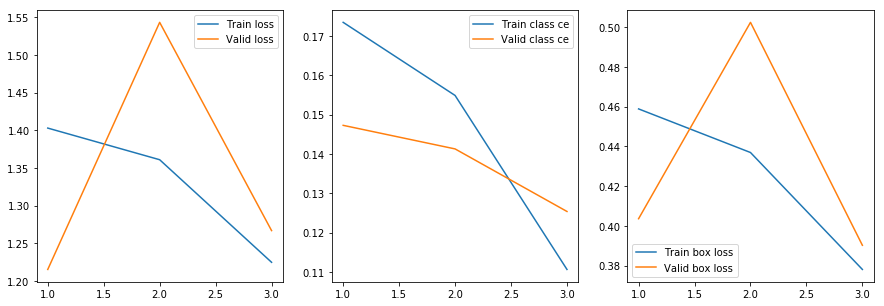

In [171]:
# Save history plot  
plot_history(model,bdbm)


In [173]:
# Print best epoch
history = model.keras_model.history.history
epochs = range(1,len(next(iter(history.values())))+1)
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])


Best Epoch: 1 1.2153515243530273


### 4. Validation

In [174]:
# Make a copy of the best model and change name
model_path = os.path.join(models_working_DIR,'pneumonia20190312T1950','mask_rcnn_pneumonia_0001.h5')

shutil.copy(model_path, bdbm)
os.rename('mask_rcnn_pneumonia_0001.h5', 'pneumonia20190312T1950_mask_rcnn_pneumonia_0001.h5')
best_model= os.path.join(bdbm,'pneumonia20190312T1950_mask_rcnn_pneumonia_0001.h5')

In [180]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=best_model)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", best_model)
model.load_weights(best_model, by_name=True)


Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/pneumonia20190312T1950_mask_rcnn_pneumonia_0001.h5



*** No instances to display *** 

637

*** No instances to display *** 

731

*** No instances to display *** 

1191

*** No instances to display *** 

854
836

*** No instances to display *** 

1092


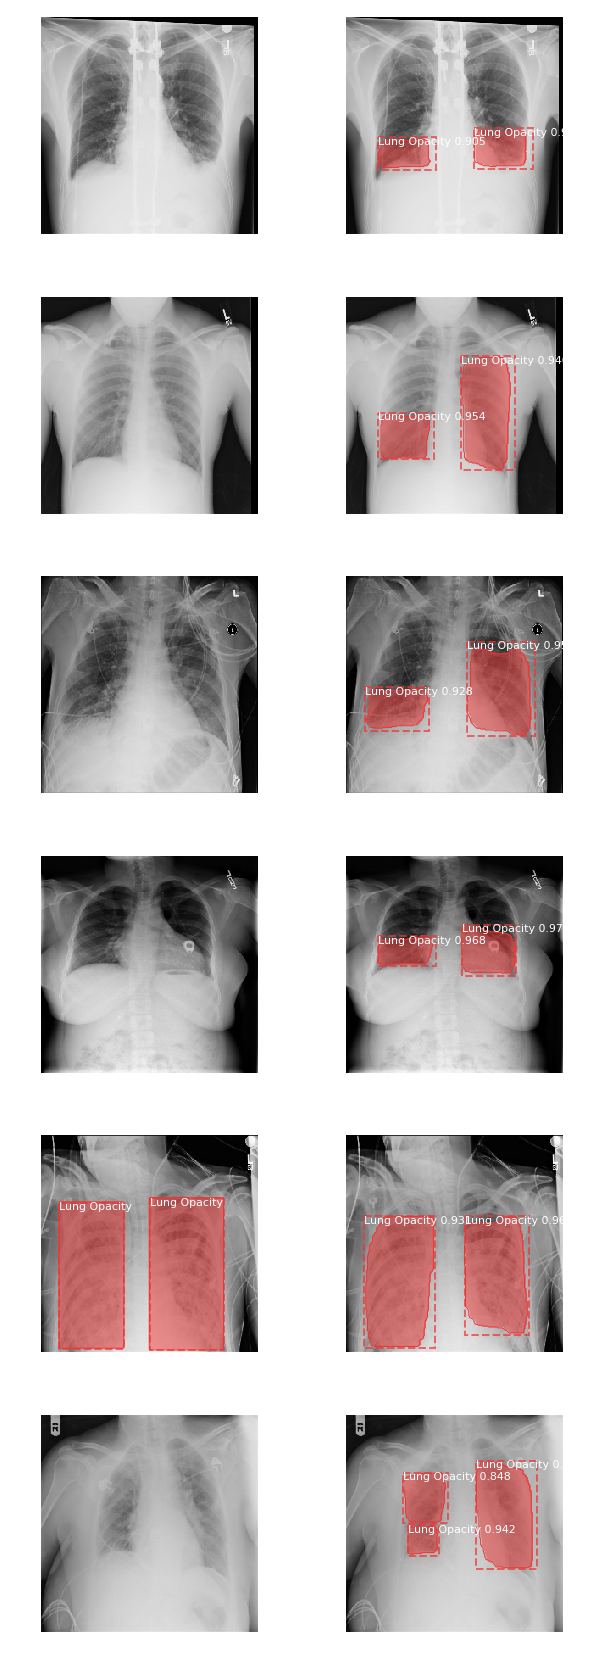

In [185]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_validate
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_validate, inference_config, 
                               image_id, use_mini_mask=False)
    
    #print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, #verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    print(image_id)
    
    


In [ ]:
# Test on validation
filename = '{}{:%Y%m%dT%H%M%S}.csv'.format(('big_data_big_model_augm_minimask_lr0.001_validation'), datetime.datetime.now())


In [186]:
validation_result_fp = os.path.join(bdbm, filename)
print('Inference Result on validation dataset is saved in', validation_result_fp)
predict(image_fps_validate, filepath=validation_result_fp)


  0%|          | 1/1334 [00:00<03:59,  5.56it/s]

Inference Result on validation dataset is saved in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/big_data_big_model/big_data_big_model_augm_minimask_lr0.001_validation20190312T203141.csv


100%|██████████| 1334/1334 [04:16<00:00,  5.17it/s]
